In [15]:
# Imports
from env import host, user, password
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
np.random.seed(42)

# Initial data pull and looking at / seeking to understand data

In [ ]:
df = w.get_zillow_data()

In [ ]:
df.head()

In [ ]:
df.columns = ['parcelid', 'bathrooms', 'bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year'
              , 'county', 'cityid', 'zip', 'lat', 'long', 'rawcensus', 'censustract_block', 'property_value']

In [ ]:
df.head()

In [ ]:
df.has_pool = df.has_pool.fillna(0)

In [ ]:
df.info()

In [ ]:
# decided to drop nulls (1505 rows worth accounts for < 3% of rows
df = df.dropna()
df.shape

In [ ]:
intcolumns = ['bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year', 'county', 'cityid', 'zip', 'censustract_block', 'property_value']
for col in intcolumns:
    df[col] = df[col].astype(int)

In [ ]:
df.head()

In [ ]:
# make the county column human readable
df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})
df.head()

In [ ]:
# if these are even useful, they will be useful in the format degrees.decimal_degrees
df.lat = df.lat / 1_000_000
df.long = df.long / 1_000_000

In [ ]:
df.head()

In [ ]:
# 175 different cityid values
df.cityid.value_counts()

# 378 different zip values
df.zip.value_counts()

# 30,741 different censustract_block values
df.censustract_block.value_counts()

# 3 different values for county, which we already knew. will keep
df.county.value_counts()

In [ ]:
# for now, I will keep only these columns. Maybe the others will have use later
keep = ['property_value', 'bathrooms', 'bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year', 'county']
df = df[keep]
df.head()

In [ ]:
df.has_pool.value_counts()

In [ ]:
dummy_df = pd.get_dummies(df[['county']], drop_first=True)
df = pd.concat([df, dummy_df], axis=1)
df.head()

In [ ]:
def wrangle_zillow():
    """
    This function will acquire and prep specific column data from zillow database. 
    Specifically it will:
    - 1. get data from database
    - 2. rename the columns to something more useful
    - 3. change has_pool nulls to 0
    - 3. drop the remaining nulls
    - 4. changes the datatype to int for all numeric columns except bathrooms
    - 5. drop outliers (property_value > $1.5M and lotsize_sqft > 60000
    
    - returns a df that looks like this:
        - property_value - int (property_value is the target)
        - bathrooms - float
        - bedrooms - int
        - has_pool - int (0 or 1)
        - squarefeet - int
        - year - int
        - county - string
        - county_Orange - int
        - county_Ventura - int
    """
    # first get the data from csv or sql
    df = get_zillow_data()
    
    #rename columns to something less unwieldy
    df.columns = ['parcelid', 'bathrooms', 'bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year'
                  , 'county', 'cityid', 'zip', 'lat', 'long', 'rawcensus', 'censustract_block', 'property_value']
    
    # has_pool has many nulls; I am making the assumption these properties do not have pools
    df.has_pool = df.has_pool.fillna(0)
    
    # decided to drop the rest of the nulls since it was < 3% of data
    df = df.dropna()
    
    # most numeric columns can/should be integers; exception was bathrooms which I left as a float
    intcolumns = ['bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year', 'county'
                  , 'cityid', 'zip', 'censustract_block', 'property_value']
    for col in intcolumns:
        df[col] = df[col].astype(int)
    
    # county really should be a categorical, since it represents a county in California
    df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

    # if these are even useful, they will be useful in the format degrees.decimal_degrees
    df.lat = df.lat / 1_000_000
    df.long = df.long / 1_000_000
    
    # for now, I will keep only these columns. Maybe the others will have use later
    keep = ['property_value', 'bathrooms', 'bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year', 'county']
    df = df[keep]
    
    # After univariate visualization, I want to purge a few outliers
    # in total, 4371 rows were cut out of 52320; ~8.4% of the data
    df = df[df.property_value <= 1_500_000]
    df = df[df.lotsize_sqft <= 60_000]
    
    # make dummy columns for the categorical column, 'county'
    dummy_df = pd.get_dummies(df[['county']], drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    
    return df

In [2]:
# get the data and clean it up
df = w.wrangle_zillow()
df.head()

csv file found and read


,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county,county_Orange,county_Ventura
0,1023282,3.5,4,0,3100,4506,1998,Orange,1,0
1,464000,1.0,2,0,1465,12647,1967,Ventura,0,1
2,564778,2.0,3,1,1243,8432,1962,Orange,1,0
3,145143,3.0,4,1,2376,13038,1970,LA,0,0
5,218552,1.0,2,0,738,4214,1922,LA,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47949 entries, 0 to 52319
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_value  47949 non-null  int64  
 1   bathrooms       47949 non-null  float64
 2   bedrooms        47949 non-null  int64  
 3   has_pool        47949 non-null  int64  
 4   squarefeet      47949 non-null  int64  
 5   lotsize_sqft    47949 non-null  int64  
 6   year            47949 non-null  int64  
 7   county          47949 non-null  object 
 8   county_Orange   47949 non-null  uint8  
 9   county_Ventura  47949 non-null  uint8  
dtypes: float64(1), int64(6), object(1), uint8(2)
memory usage: 3.4+ MB


In [ ]:
# I want to purge a few outliers
# in total, 4371 rows were cut out of 52320; ~8.4% of the data
# df = df[df.property_value <= 1_500_000]
# df = df[df.lotsize_sqft <= 60_000]
# df.shape

# Visualization of univariate variables

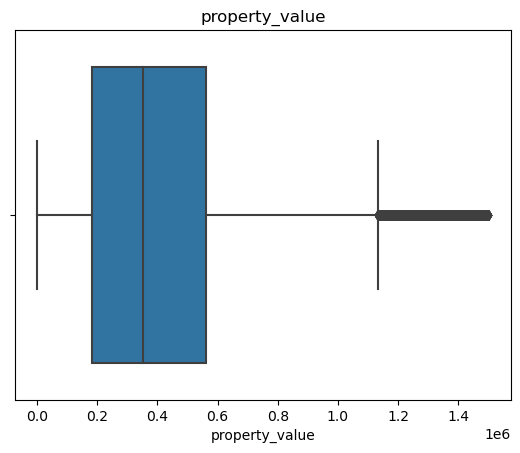

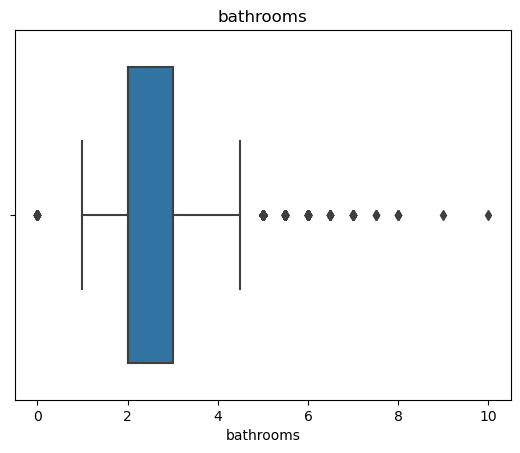

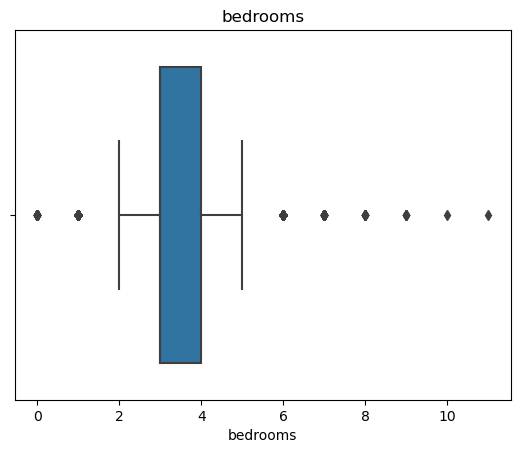

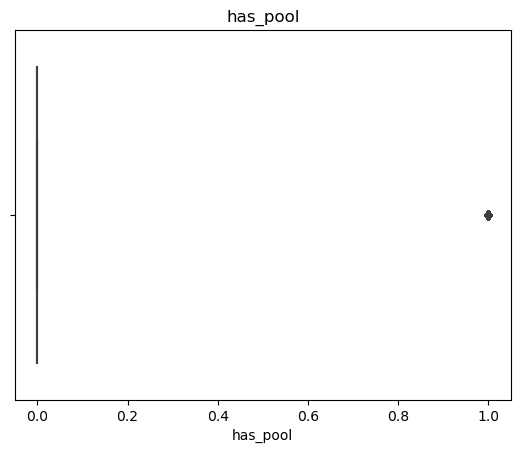

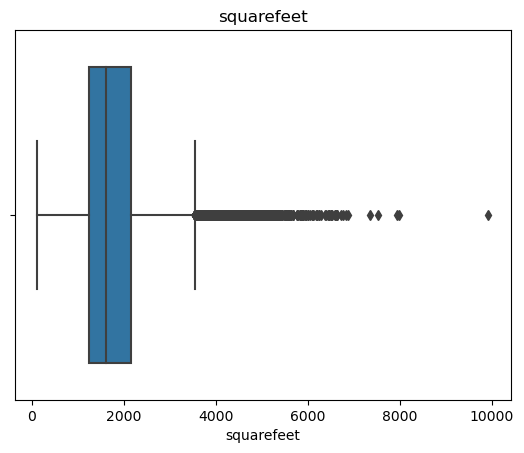

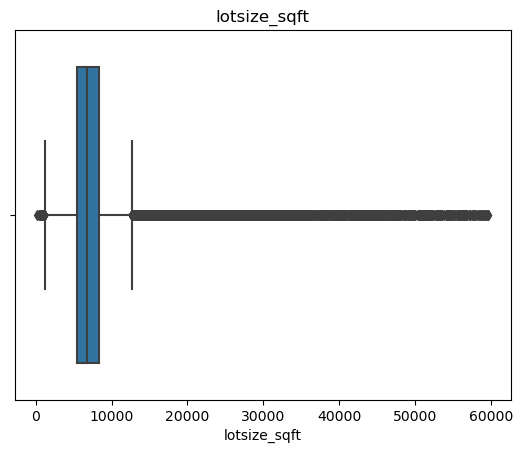

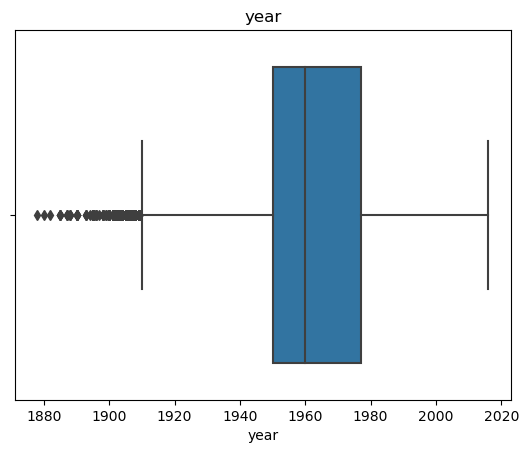

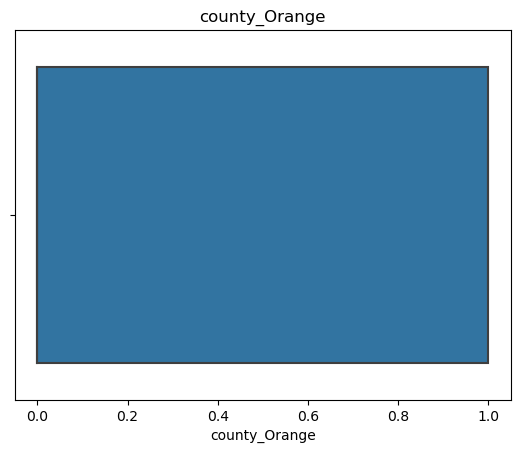

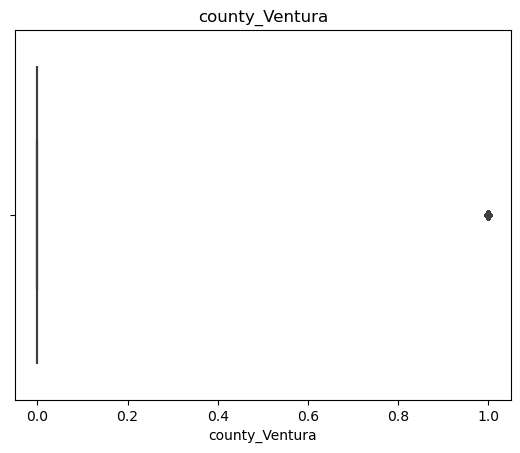

In [4]:
# visualize to see outliers
for col in df.columns[df.columns != 'county']:
    sns.boxplot(data = df, x=col)
    plt.title(col)
    plt.show()

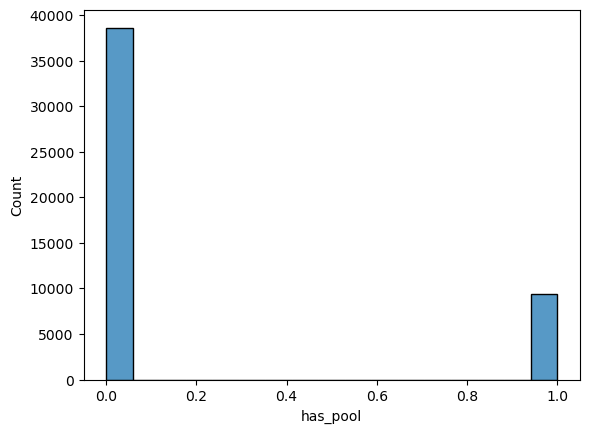

0    38615
1     9334
Name: has_pool, dtype: int64

In [5]:
sns.histplot(df.has_pool)
plt.show()
df.has_pool.value_counts()

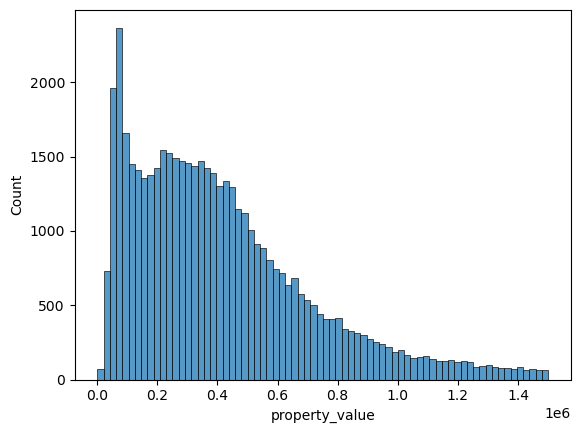

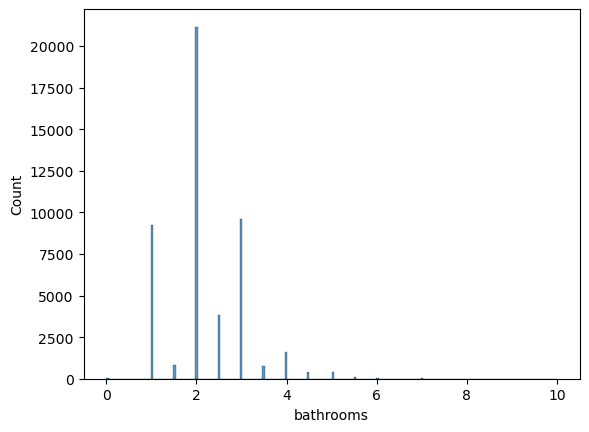

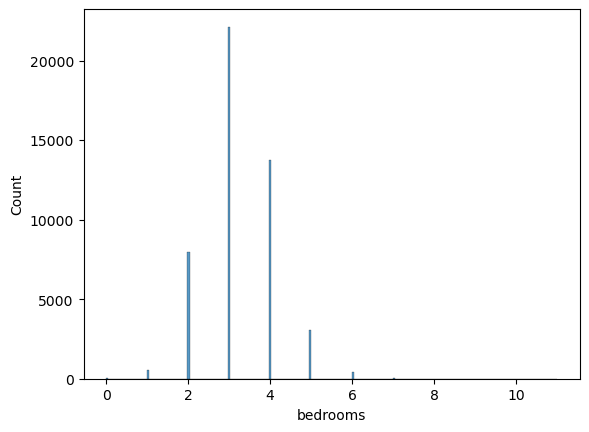

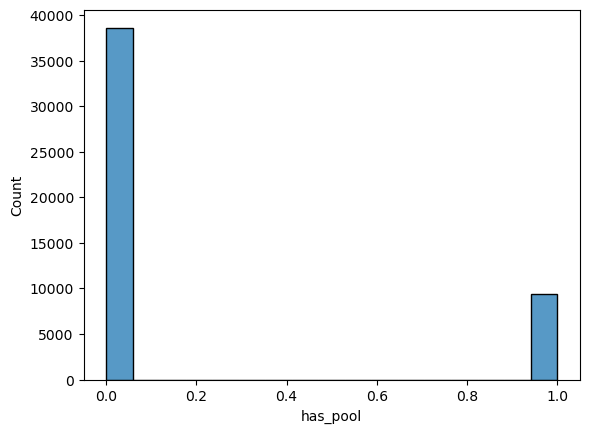

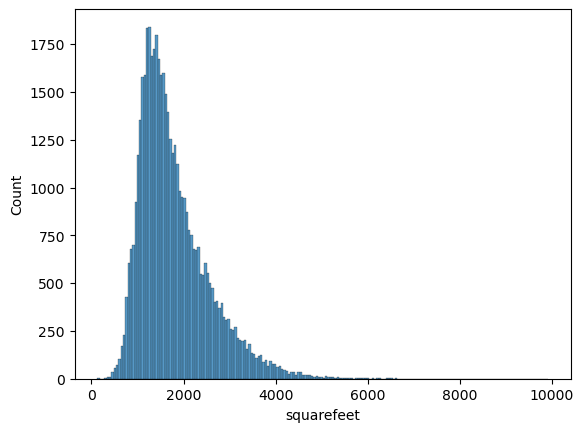

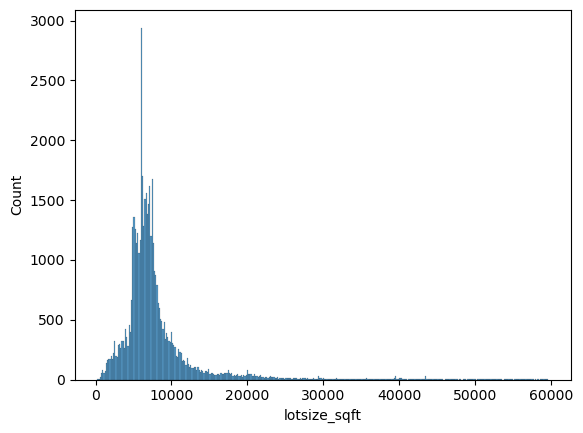

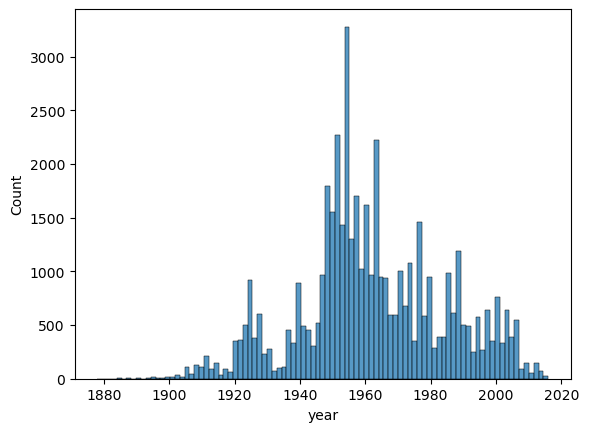

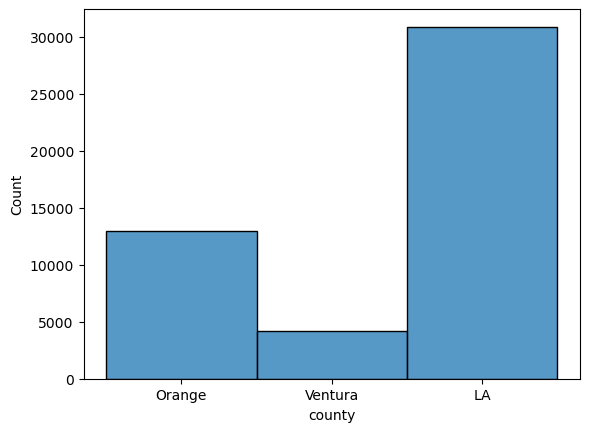

In [9]:
for col in ['property_value', 'bathrooms', 'bedrooms', 'has_pool', 'squarefeet', 'lotsize_sqft', 'year', 'county']:
    sns.histplot(data = df, x=col)
    plt.show()

In [8]:
df.head()

,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county,county_Orange,county_Ventura
0,1023282,3.5,4,0,3100,4506,1998,Orange,1,0
1,464000,1.0,2,0,1465,12647,1967,Ventura,0,1
2,564778,2.0,3,1,1243,8432,1962,Orange,1,0
3,145143,3.0,4,1,2376,13038,1970,LA,0,0
5,218552,1.0,2,0,738,4214,1922,LA,0,0


In [ ]:
df = w.wrangle_zillow()

In [ ]:
df.shape

<AxesSubplot:xlabel='bathrooms', ylabel='Count'>

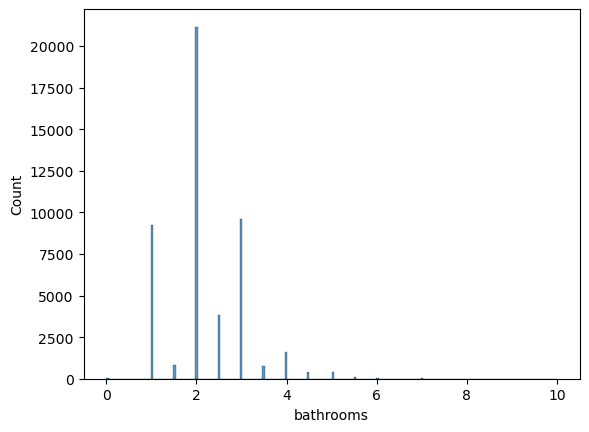

In [22]:
# I'm going to look at making a column has_half_bath
sns.histplot(df.bathrooms)
# maybe later

# Split into train, validate, test 
- dummy columns are already made
- scaling has not been done yet

In [12]:
train, validate, test = w.split_function(df)

Prepared df: (47949, 10)

Train: (28769, 10)
Validate: (9590, 10)
Test: (9590, 10)


In [13]:
train.head()

,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county,county_Orange,county_Ventura
46866,476000,2.0,3,0,1606,6447,1955,LA,0,0
43125,567337,2.5,4,1,2642,7912,1977,Orange,1,0
38231,419390,1.0,2,0,924,7155,1948,LA,0,0
20644,409000,1.0,3,0,1402,7165,1953,LA,0,0
46076,342514,3.0,4,0,2826,23650,1978,Orange,1,0


## Visualize scaler options

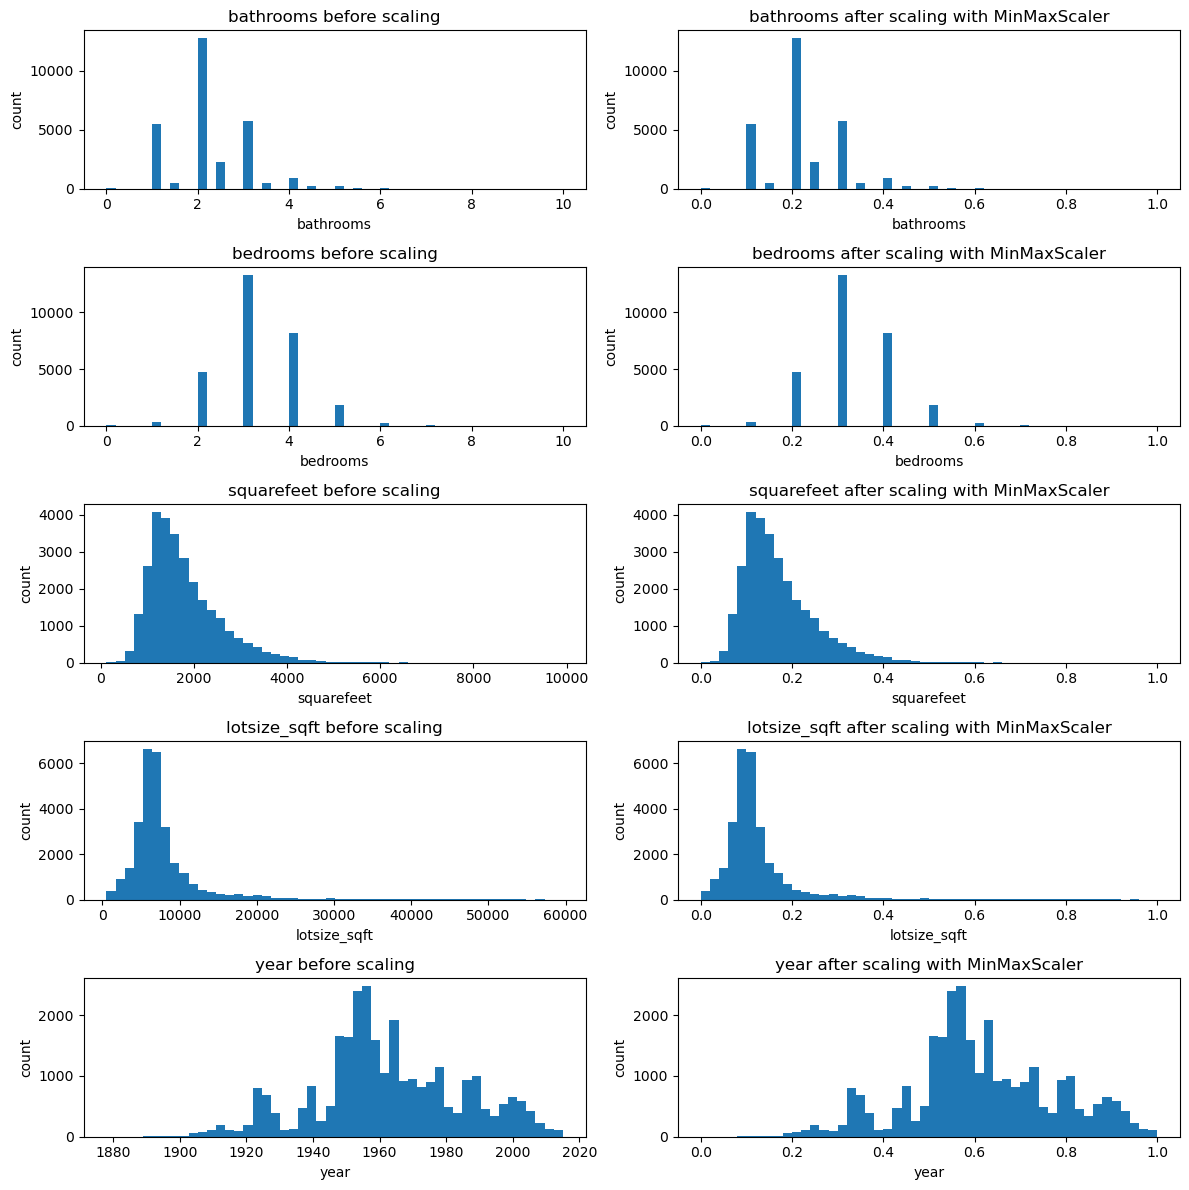

In [16]:
to_scale = ['bathrooms', 'bedrooms', 'squarefeet', 'lotsize_sqft', 'year']
w.visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

## Scaling Decision:
- looked at MinMaxScaler, StandardScaler, RobustScaler, and QuantileTransformer
- MinMax looks good.

In [23]:
to_scale = ['bathrooms', 'bedrooms', 'squarefeet', 'lotsize_sqft', 'year']
train_scaled, validate_scaled, test_scaled = w.get_minmax_scaled(train, validate, test, to_scale)

In [24]:
train_scaled.head()

,property_value,bathrooms,bedrooms,has_pool,squarefeet,lotsize_sqft,year,county,county_Orange,county_Ventura
46866,476000,0.20,0.3,0,0.150970,0.099934,0.562044,LA,0,0
43125,567337,0.25,0.4,1,0.256793,0.124719,0.722628,Orange,1,0
38231,419390,0.10,0.2,0,0.081307,0.111912,0.510949,LA,0,0
20644,409000,0.10,0.3,0,0.130133,0.112081,0.547445,LA,0,0
46076,342514,0.30,0.4,0,0.275587,0.390973,0.729927,Orange,1,0


# Summary of wrangle
- 52,320 rows prior to cleaning
- 47,949 rows after cleaning
- nulls represented < 3% of data, so I removed them
- Outliers represented ~5% of the data
    - I chose to discard rows with property_value > 1,500,000
    - I also chose to discard rows with lotsize_sqft > 60,000
    - Excluding these values allowed me to see where the majority of my data was, and it only excluded ~5% of the data
- 8 columns 6 numeric, 2 categorical
    - 1 target (target is numeric and continuous), 7 features
    - Of the 7 features: 5 numeric, 2 categorical 
- changed all numeric columns to int except bathrooms which stayed float
- pools became has_pool: 0 for no pool, 1 for has_pool
- one numeric column, fips (now county), is actually categorical, and it has 3 unique values: 6037, 6059, 6111
    - fips represents a region code akin to zip code (fips stands for federal information processing system)
    - 6037 == '06037' which is Los Angeles County in CA
    - 6059 == '06059' which is Orange County, CA
    - 6111 == '06111' which is Ventura County, CA

- each row is a "Single Family Residential" property from a 2017 Zillow database with a transaction date in the year 2017
- each column is an attribute of that house.
- most numeric columns have normally distributed values with right skew (right tails, mean greater than median)
    - which indicates a smaller number of higher values (square feet, tax_value, etc.)
    - which also indicates that a small number of these properties are big/high-value "mansion" type houses
- county distribution:
    - 30,871 homes in 6037 (LA County)
    - 12,917 homes in 6059 (Orange County) 
    -  4,161 homes in 6111 (Ventura County)

- preprocessing for modeling phase later:
    - scaled numeric columns using MinMaxScaler
    - made dummy columns for county